# CROP-seq KO15 - Mixscape analysis of each condition separately
- input: filtered seurat object
- output: real perturbed cells, LDA UMAP plot,...

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(dplyr)
library(reshape2)
library(stringr)
library(ggrepel)


# Setup custom theme for plotting.
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# configs
data_path <- file.path('results','KO15')

fine_mode <- FALSE
# fine_mode <- TRUE

if (fine_mode){
    mixscape_dir = "mixscape_finemode"
} else{
    mixscape_dir = "mixscape"
}

# cond <- 'untreated'
# cond <- 'LO28_2h'
cond <- 'LO28_6h'

results_path <- file.path(data_path, mixscape_dir, cond)

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE, recursive = TRUE)

# load filtered Seurat object

In [5]:
# loading Seurat object
KO15 <-readRDS(file = file.path(data_path,paste0("KO15_filtered_Seurat.rds")))
KO15

An object of class Seurat 
31135 features across 9153 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

## prepare metadata

In [6]:
KO15[['condition']] <- str_split_fixed(KO15$hto_demux, "_", 2)[,2]
unique(KO15$condition)

[1] "LO28_2h"   "untreated" "LO28_6h"

# filter for condition 

In [7]:
# filter by condition
KO15 <- subset(KO15, subset = condition == cond)
KO15

An object of class Seurat 
31135 features across 3072 samples within 4 assays 
Active assay: RNA (31053 features, 0 variable features)
 3 other assays present: AB, gRNA, HTO

In [8]:
unique(KO15$condition)

[1] "LO28_6h"

# prepare seurat object for mixscape analysis
ie create new columns, named accoring to example data of vignette

In [9]:
# column gene
KO15[["gene"]] <- substring(KO15$KO_call,2)
KO15$gene[KO15$gene=="Non-targeting"] <- 'NT'

In [10]:
# column NT
KO15[["NT"]] <- substring(str_replace(KO15$guide_call, '_', 'g'),2)
KO15$NT[grep("^Non-targeting",KO15$NT)] <- 'NT'

In [11]:
# column crispr for distinguishing perturbed & non-perturbed cells
KO15[["crispr"]] <- KO15$gene
KO15$crispr[KO15$crispr!="NT"] <- "Perturbed"

In [12]:
KO15[[c("gene","NT","crispr")]][1:10,]

,gene,NT,crispr
,<chr>,<chr>,<chr>
1_AAACCTGCAGGCAGTA-1,NT,NT,NT
1_AAACCTGCAGTCGTGC-1,Hdac6,Hdac6g2,Perturbed
1_AAACCTGTCACTCCTG-1,Stat1,Stat1g3,Perturbed
1_AAACGGGAGCCAGAAC-1,Tyk2,Tyk2g4,Perturbed
1_AAACGGGCACCGTTGG-1,Irf9,Irf9g1,Perturbed
1_AAACGGGCATAACCTG-1,Tyk2,Tyk2g4,Perturbed
1_AAACGGGTCAGGCCCA-1,Irf8,Irf8g4,Perturbed
1_AAACGGGTCCTCATTA-1,Ep300,Ep300g4,Perturbed
1_AAACGGGTCTAACCGA-1,Ep300,Ep300g4,Perturbed


# Mixscape

In [13]:
# Normalize protein.
KO15 <- NormalizeData(
  object = KO15, 
  assay = "AB", 
  normalization.method = "CLR", 
  margin = 2)

Normalizing across cells



In [14]:
# Prepare RNA assay for dimensionality reduction: 
# Normalize data, find variable features and scale data.
DefaultAssay(object = KO15) <- 'RNA'
KO15 <- NormalizeData(object = KO15) %>% FindVariableFeatures() %>% ScaleData()

# Run Principle Component Analysis (PCA) to reduce the dimensionality of the data.
KO15 <- RunPCA(object = KO15)

# Run Uniform Manifold Approximation and Projection (UMAP) to visualize clustering in 2-D.
KO15 <- RunUMAP(object = KO15, dims = 1:40)

Centering and scaling data matrix

PC_ 1 
Positive:  Hmgb2, Top2a, Pclaf, Cdk1, Birc5, Mki67, Tubb5, Cks1b, Ube2c, Ccna2 
	   Tipin, Smc2, Ube2s, Tmpo, Cenpa, H2afz, Ptma, Cdca8, Tpx2, Fen1 
	   Pbk, Stmn1, Knl1, Smc4, H2afx, Rrm1, Hmgb1, Ckap2l, Tuba1b, Tubb4b 
Negative:  Lgals3, Lilr4b, Rsad2, Cmpk2, Ifit1, Oasl1, Ifit2, Acod1, Ifih1, Isg15 
	   Sqstm1, Ccrl2, Ccl9, Ctsb, Npc2, Cstb, Ccl4, Plk2, Ftl1, Ifi202b 
	   Slfn4, Rgs1, Ifit3, Zfp36, Tmem106a, Lilrb4a, AC133103.1, Plin2, Mndal, C3ar1 
PC_ 2 
Positive:  Herpud1, Pou2f2, Stap1, Il4i1, Srm, Cebpd, Il1b, mt-Cytb, Cd72, Tmem176b 
	   P2ry6, Fnbp1l, Ets2, Car2, Ptpn6, Cited2, Apbb1ip, Pdgfb, Fyb, Nfkbiz 
	   Ikzf1, Gpr84, Cpd, Slc16a3, Kcnn4, Rhof, Ccnd1, Lrrc25, St3gal6, Nfkbia 
Negative:  Rsad2, Oasl1, Cxcl10, Isg15, Ifih1, Cmpk2, AC133103.1, Ifit1, AC168977.1, C130026I21Rik 
	   Sp140, Ccrl2, Peli1, Ccl5, Ifnb1, Csrnp1, Polr2g, Ppp1r15a, Ifit2, Fbxo15 
	   A530040E14Rik, Tiparp, Slc39a2, Ifi207, Ifrd1, Atf3, H3f3b, Oser1, Slc3a2,

In [15]:
mouseHumanGenes <- read.table(file = file.path("resources","HOM_MouseHumanSequence.rpt"), sep = '\t', header = TRUE)

In [16]:
# convert human cell cycle genes to murine genes
m.g2m.genes <- vector()

for (human_gene in cc.genes$g2m.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.g2m.genes <- append(m.g2m.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.g2m.genes

In [17]:
# convert human cell cycle genes to murine genes
m.s.genes <- vector()

for (human_gene in cc.genes$s.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.s.genes <- append(m.s.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.s.genes

In [18]:
# perform cell cycle scoring

# convert human cell cycle genes to murine genes -> NOT WOKRING bc Ensembl site unresponsive!!!!
# m.s.genes <- convertHumanGeneList(cc.genes$s.genes)# cc.genes.updated.2019$s.genes
# m.g2m.genes <- convertHumanGeneList(cc.genes$g2m.genes) # cc.genes.updated.2019$g2m.genes

# determine cell cycle scores
s.genes <- m.s.genes
g2m.genes <- m.g2m.genes
KO15 <- CellCycleScoring(KO15, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [19]:
DefaultAssay(object = KO15) <- 'RNA'

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



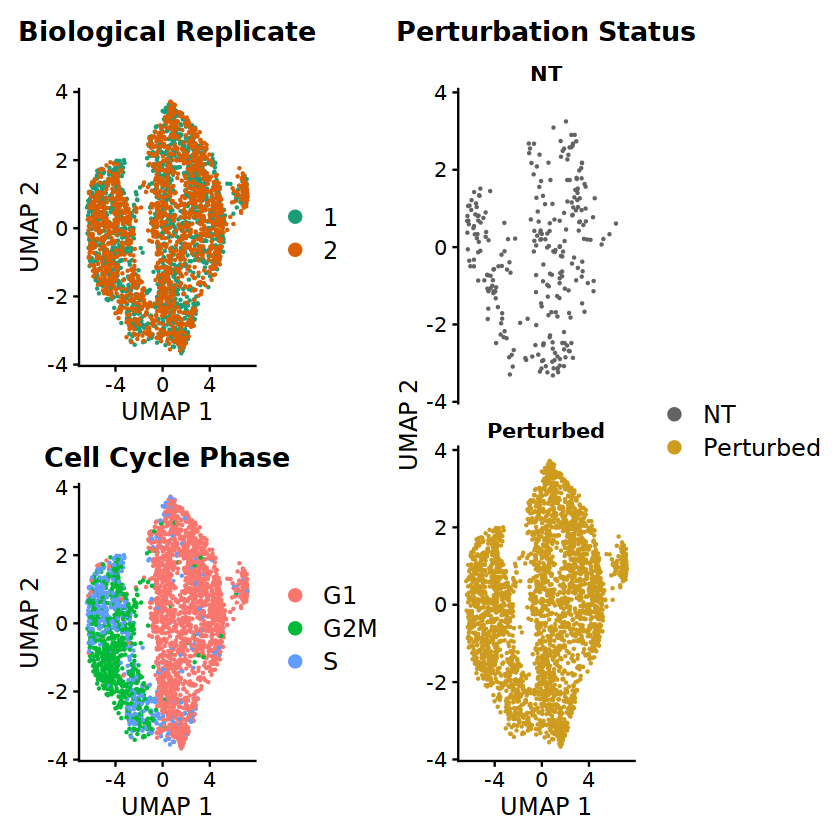

In [20]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
p1 <- DimPlot(
  object = KO15, 
  group.by = 'batch', 
  label = F, 
  pt.size = 0.2, 
  reduction = "umap", cols = "Dark2", repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  xlab("UMAP 1") +
  ylab("UMAP 2") +
  custom_theme

p2 <- DimPlot(
  object = KO15, 
  group.by = 'Phase', 
  label = F, pt.size = 0.2, 
  reduction = "umap", repel = T) + 
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

p3 <- DimPlot(
  object = KO15, 
  group.by = 'crispr', 
  pt.size = 0.2, 
  reduction = "umap", 
  split.by = "crispr", 
  ncol = 1, 
  cols = c("grey39","goldenrod3")) + 
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
((p1 / p2 + plot_layout(guides = 'auto')) | p3 )
# ((p1 / p1 + plot_layout(guides = 'auto')) | p3 )

ggsave(
  paste0("KO15_","_UMAP_prePerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [21]:
# Calculate perturbation signature (PRTB).
KO15 <- CalcPerturbSig(
  object = KO15, 
  assay = "RNA", 
  slot = "data", 
  gd.class ="gene", 
  nt.cell.class = "NT", 
  reduction = "pca", 
  ndims = 40, 
  num.neighbors = 30, 
#   split.by = "replicate", 
  new.assay.name = "PRTB")

Processing rep1



In [22]:
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = KO15) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = KO15) <- VariableFeatures(object = KO15[["RNA"]])
KO15 <- ScaleData(object = KO15, do.scale = F, do.center = T)

# Run PCA to reduce the dimensionality of the data.
KO15 <- RunPCA(object = KO15, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
KO15 <- RunUMAP(
  object = KO15, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Centering data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Irf7, Usp18, Isg15, Rsad2, Ifi27l2a, Isg20, Ifit1, Cmpk2, Bst2, Ifit2 
	   Ifi44, Phf11d, Ly6e, Ifit3, Oasl1, Ifi202b, Slfn4, Rtp4, Rnf213, Xaf1 
	   Cxcl10, Oasl2, Irgm1, Ifi207, Apol9a, Tor3a, Ifitm3, Ddx58, Daxx, Lgals9 
Negative:  H2-Eb1, Cxcl2, H2-Aa, Fth1, Edn1, Herpud1, Cd52, Srm, Cyth4, Lyz2 
	   Vim, Cd72, Naa50, Ifnb1, Cd74, mt-Cytb, Tnip3, Mt1, Slc16a3, Phlda1 
	   Lpl, Gpr84, Mt2, Clec4d, Cfp, Prdx1, Dcstamp, Hmgn1, Ets2, Spp1 
prtbpca_ 2 
Positive:  Cxcl2, Il1b, Il1a, Ccl3, Ccl4, Tnf, Ccl9, Ptgs2, Acod1, Phlda1 
	   Lilr4b, Odc1, Ccl5, Nfkbiz, Spp1, Cd52, Cybb, Rgs1, Marcksl1, Cd14 
	   Hivep3, Cd72, Pim1, Atf3, Stap1, Plaur, Car2, Junb, Malt1, Mir155hg 
Negative:  Akr1

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



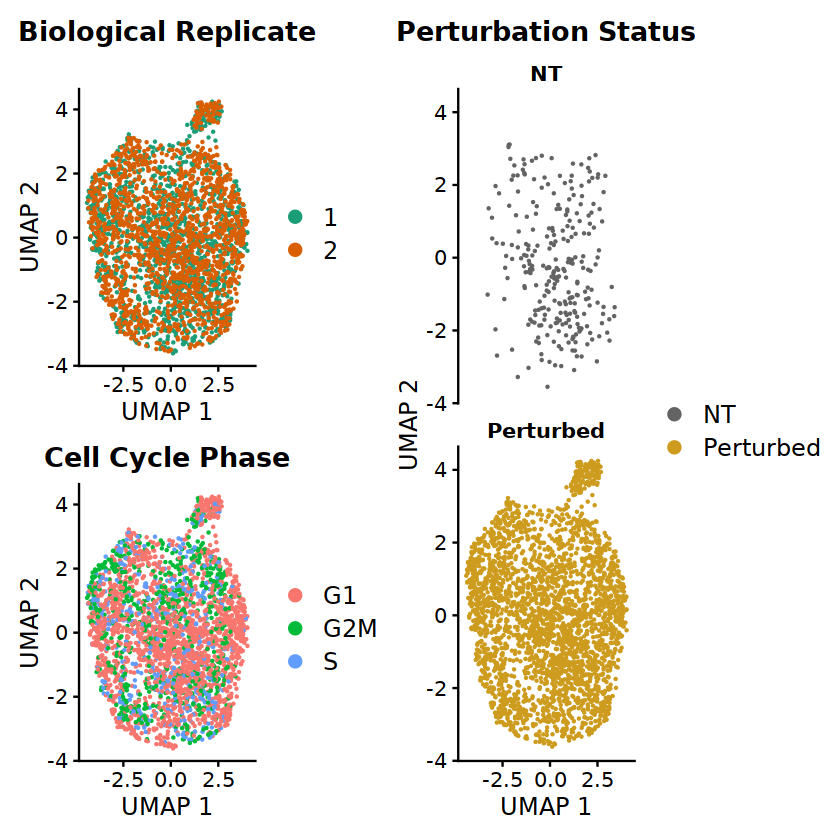

In [23]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
q1 <- DimPlot(
  object = KO15, 
  group.by = 'batch', 
  reduction = 'prtbumap', 
  pt.size = 0.2, cols = "Dark2", label = F, repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

q2 <- DimPlot(
  object = KO15, 
  group.by = 'Phase', 
  reduction = 'prtbumap', 
  pt.size = 0.2, label = F, repel = T) +
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") + 
  custom_theme

q3 <- DimPlot(
  object = KO15,
  group.by = 'crispr',
  reduction = 'prtbumap', 
  split.by = "crispr", 
  ncol = 1, 
  pt.size = 0.2, 
  cols = c("grey39","goldenrod3")) +
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
(q1 / q2 + plot_layout(guides = 'auto') | q3)
# (q1 / q1 + plot_layout(guides = 'auto') | q3)

ggsave(
  paste0("KO15_","_UMAP_postPerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [24]:
# Run mixscape.
KO15 <- RunMixscape(
  object = KO15, 
  assay = "PRTB", 
  slot = "scale.data", 
  labels = "gene", 
  nt.class.name = "NT", 
  min.de.genes = 5, 
  iter.num = 10, 
  de.assay = "RNA", 
  verbose = F,
    fine.mode = fine_mode,
  fine.mode.labels = "NT",
  prtb.type = "KO",
    logfc.threshold = 0.1 # default 0.25
)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


number of iterations= 78 
number of iterations= 72 
number of iterations= 70 
number of iterations= 415 
number of iterations= 112 
number of iterations= 108 
number of iterations= 104 
number of iterations= 104 
number of iterations= 11 
number of iterations= 7 
number of iterations= 8 
number of iterations= 67 
number of iterations= 38 
number of iterations= 36 
number of iterations= 24 
number of iterations= 22 
number of iterations= 22 
number of iterations= 12 
number of iterations= 8 
number of iterations= 86 
number of iterations= 51 
number of iterations= 49 
number of iterations= 11 
number of iterations= 7 
number of iterations= 14 
number of iterations= 10 


In [25]:
# save Seurat object
saveRDS(KO15, file = file.path(results_path,paste0("KO15_mixscape_Seurat.rds")))

In [26]:
# loading Seurat object
KO15 <-readRDS(file = file.path(results_path,paste0("KO15_mixscape_Seurat.rds")))
KO15

An object of class Seurat 
33349 features across 3072 samples within 5 assays 
Active assay: PRTB (2214 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [27]:
# save matrix of PRTB counts
PRTB <- GetAssayData(object = KO15, slot = "data")
dim(PRTB)
head(PRTB)
write.csv(PRTB, file=file.path(results_path,paste0('KO15_mixscape_PRTB','.csv')), row.names=TRUE)

[1] 2214 3072

,1_AAACCTGCAGGCAGTA-1,1_AAACCTGCAGTCGTGC-1,1_AAACCTGTCACTCCTG-1,1_AAACGGGAGCCAGAAC-1,1_AAACGGGCACCGTTGG-1,1_AAACGGGCATAACCTG-1,1_AAACGGGTCAGGCCCA-1,1_AAACGGGTCCTCATTA-1,1_AAACGGGTCTAACCGA-1,1_AAAGATGAGAATTCCC-1,⋯,2_TTTGCGCCACCGATAT-1,2_TTTGCGCGTTCATGGT-1,2_TTTGCGCTCTAAGCCA-1,2_TTTGGTTAGAGGGCTT-1,2_TTTGGTTAGCGCCTTG-1,2_TTTGGTTCATGCATGT-1,2_TTTGGTTTCCGGGTGT-1,2_TTTGGTTTCGTTGCCT-1,2_TTTGGTTTCTACTCAT-1,2_TTTGTCAGTGACCAAG-1
Ccl2,-1.06449797,1.6911234,0.97022426,2.48157000,1.0597934,1.3042598,0.25232520,0.77814964,1.13688375,0.8274322,⋯,0.6406538,2.71542161,1.04240998,0.26910729,-0.06409131,-0.36426930,1.8432737,2.02722002,2.78782157,1.3748072
Csf2,0.36212407,0.8048055,1.37199187,0.94568743,1.8819210,0.6691076,0.97576610,1.24910939,1.01906560,0.2075529,⋯,0.8064584,0.03554120,1.25595142,1.66543448,0.39143606,0.36364475,0.3930109,0.10342189,1.77093230,1.5724725
Ifnb1,3.07469514,0.8995409,0.34914258,-0.67533519,1.4004143,-0.2802609,-2.31338825,0.82176789,1.75556621,0.1954368,⋯,1.8930633,1.17071909,0.08260836,0.04738326,0.96245531,1.89741147,1.0211914,3.02946328,0.80183189,1.1441038
Ccl7,1.01232787,0.0000000,0.02746218,0.13089262,0.1117607,1.5600090,0.02746218,0.02746218,0.23259503,0.1790649,⋯,0.4346459,0.16010566,0.52241720,0.02746218,0.96895337,-0.09709320,0.5224172,1.75837348,1.46157150,0.2325950
Saa3,0.02090377,0.0000000,0.02157767,0.07427601,0.2010224,0.1167961,0.02157767,0.08135217,0.02157767,-1.7049495,⋯,0.0000000,0.02951982,-1.18933459,0.00000000,0.00000000,0.02090377,0.6809446,0.02090377,0.02090377,0.0000000
Ppp1r15a,0.88403744,-0.2810335,0.99810482,-0.39604772,0.5212379,-0.7409783,-1.22399110,0.26041708,-0.52465542,0.8064734,⋯,0.7462816,0.26974087,0.69800031,0.70921889,1.90466374,0.43415137,1.0785628,1.55615091,-0.61043800,0.7481834


In [28]:
# save mixscape annotation data
write.csv(
    KO15[[c('mixscape_class', 'mixscape_class_p_ko', 'mixscape_class.global')]],
    file = file.path(results_path,paste0("KO15_mixscape_annotations.csv")),
    row.names=TRUE
    )

Saving 6.67 x 6.67 in image



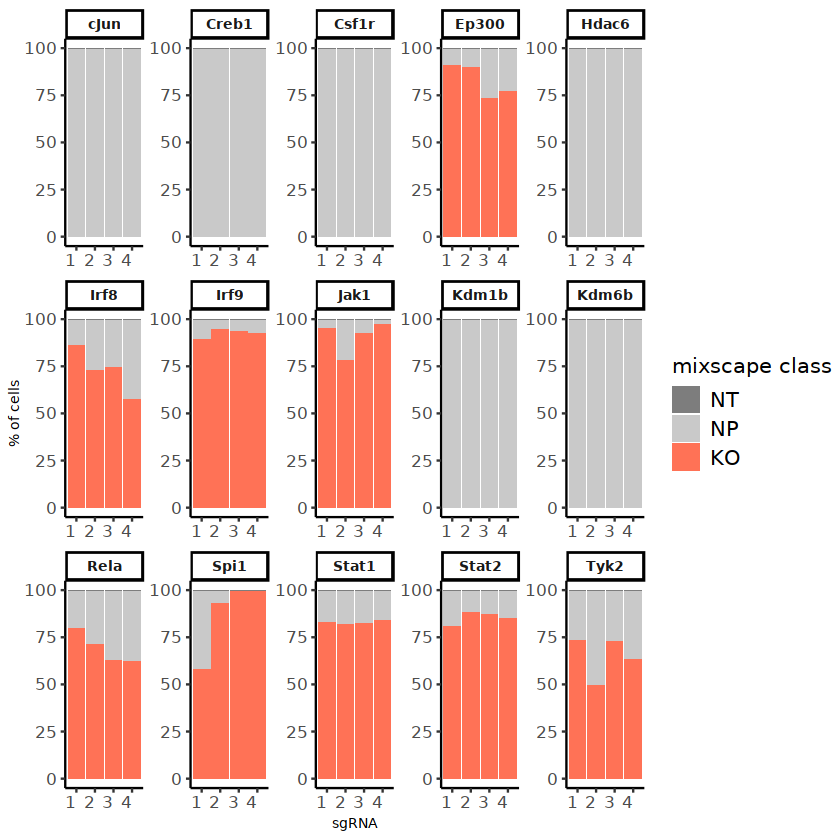

In [29]:
# Calculate percentage of KO cells for all target gene classes.
df <- prop.table(table(KO15$mixscape_class.global, KO15$NT),2)

df2 <- reshape2::melt(df)
df2$Var2 <- as.character(df2$Var2)
test <- df2[which(df2$Var1 == "KO"),]
test <- test[order(test$value, decreasing = T),]
new.levels <- test$Var2
df2$Var2 <- factor(df2$Var2, levels = new.levels )
df2$Var1 <- factor(df2$Var1, levels = c("NT", "NP", "KO"))
df2$gene <- sapply(as.character(df2$Var2), function(x) gsub("g.$", "", x))
df2$guide_number <- sapply(as.character(df2$Var2), 
                           function(x) tail(strsplit(x, split = "g")[[1]],1))
df3 <- df2[-c(which(df2$gene == "NT")),]

p1 <- ggplot(df3, aes(x = guide_number, y = value*100, fill= Var1)) +
  geom_bar(stat= "identity") +
  theme_classic()+
  scale_fill_manual(values = c("grey49", "grey79","coral1")) + 
  ylab("% of cells") +
  xlab("sgRNA")

p1 + theme(axis.text.x = element_text(size = 10, hjust = 1), 
           axis.text.y = element_text(size = 10), 
           axis.title = element_text(size = 8), 
           strip.text = element_text(size=8, face = "bold")) + 
  facet_wrap(vars(gene),ncol = 5, scales = "free") +
  labs(fill = "mixscape class") +theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12))

ggsave(
  paste0("KO15_","_PercentageKO_all",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [30]:
# Explore the perturbation scores of cells.
Idents(object = KO15) <- 'mixscape_class'

for (gene in unique(KO15$gene)){
    if (gene=="NT" | length(unique(KO15$mixscape_class.global[KO15$gene==gene]))==1){
        next
    }
    print(gene)
    PlotPerturbScore(object = KO15,
                     target.gene.ident = gene, 
                     group.by = "mixscape_class", 
                     col = "coral2") + labs(fill = "mixscape class")
    ggsave(
      paste0("KO15_","_PerturbScore_",gene,".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

[1] "Stat1"


Saving 6.67 x 6.67 in image



[1] "Tyk2"


Saving 6.67 x 6.67 in image



[1] "Irf9"


Saving 6.67 x 6.67 in image



[1] "Irf8"


Saving 6.67 x 6.67 in image



[1] "Ep300"


Saving 6.67 x 6.67 in image



[1] "Spi1"


Saving 6.67 x 6.67 in image



[1] "Rela"


Saving 6.67 x 6.67 in image



[1] "Jak1"


Saving 6.67 x 6.67 in image



[1] "Stat2"


Saving 6.67 x 6.67 in image



In [31]:
# Inspect the posterior probability values in NP and KO cells.
Idents(object = KO15) <- 'mixscape_class'

for (gene in unique(KO15$gene)){
    if (gene=="NT"){
        next
    }

    VlnPlot(KO15, "mixscape_class_p_ko", idents = c("NT", paste0(gene," KO"), paste0(gene," NP"))) +
      theme(axis.text.x = element_text(angle = 0, hjust = 0.5),axis.text = element_text(size = 16) ,plot.title = element_text(size = 20)) + 
      NoLegend() +
      ggtitle("mixscape posterior probabilities")
    
    ggsave(
      paste0("KO15_",'violin',"_PosteriorProbability_",gene, ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = 

In [33]:
# load RNA DEA results per KO, filter for sign. genes (adj.p-value<stat_sign), order by KO porbability, make heatmap
stat_sign <- 0.05
top_n <- 40

Idents(object = KO15) <- "gene"

for (gene in unique(KO15$gene)){
#     print(gene)
    if (gene=="NT"){
        next
    }
    
    tmp_dea_genes <- read.csv(file=file.path(data_path,'DEA_condition',paste0('KO15_DEA_RNA_',cond,'_m',gene,'.csv')), row.names=1)
    sign_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
#     print(sign_genes)
    
    if(length(sign_genes)<1){
        next
    }
    
    if(!(sign_genes %in% rownames(GetAssayData(object = KO15, slot = "scale.data")))){
        next
    }

    # select cells and sort cells by their mixscape KO posterior probability
    cell_names <- names(sort(KO15$mixscape_class_p_ko[colnames(KO15)[KO15$gene==gene|KO15$gene=="NT"]], decreasing=FALSE))
    
    DoHeatmap(KO15, cells=cell_names, group.by="mixscape_class", features = sign_genes[1:top_n])
    
    ggsave(
      paste0("KO15_",'Heatmap',"_DEA_RNA_",gene,"_top",top_n,".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Warning message in if (!(sign_genes %in% rownames(GetAssayData(object = PT141, slot = "scale.data")))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in DoHeatmap(PT141, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the scale.data slot for the PRTB assay: NA, Ctss, Gsdmd, Selenow”
Saving 6.67 x 6.67 in image

Warning message in if (!(sign_genes %in% rownames(GetAssayData(object = PT141, slot = "scale.data")))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in DoHeatmap(PT141, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the scale.data slot for the PRTB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in if (!(sign_genes %in% rownames(GetAssayData(object = PT141, slot = "scale.data")))) {:
“the condition has length > 1 and only the first element will be used”
W

In [34]:
# load AB DEA results per KO, filter for sign. genes (adj.p-value<stat_sign), order by KO porbability, make heatmap
stat_sign <- 0.05
top_n <- 40

Idents(object = KO15) <- "gene"

for (gene in unique(KO15$gene)){
#     print(gene)
    if (gene=="NT"){
        next
    }
    
    tmp_dea_genes <- read.csv(file=file.path(data_path,'DEA_condition',paste0('KO15_DEA_AB_',cond,'_m',gene,'.csv')), row.names=1)
    sign_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
#     print(sign_genes)
    
    if(length(sign_genes)<1){
        next
    }
    
#     if(!(sign_genes %in% rownames(GetAssayData(object = KO15, slot = "scale.data")))){
#         next
#     }

    # select cells and sort cells by their mixscape KO posterior probability
    cell_names <- names(sort(KO15$mixscape_class_p_ko[colnames(KO15)[KO15$gene==gene|KO15$gene=="NT"]], decreasing=FALSE))
    
    DoHeatmap(KO15, cells=cell_names, group.by="mixscape_class", features = sign_genes[1:top_n], assay="AB", slot="data")
    
    ggsave(
      paste0("KO15_",'Heatmap',"_DEA_AB_",gene,"_top",top_n,".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Warning message in DoHeatmap(PT141, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT141, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT141, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT141, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT141, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not

**Mixscape Heatmap filters genes by p_val NOT by p_val_adj! AND it outputs only positive LFCs!! -> DO NOT USE IT!**

In [37]:
# Protein expression pathways
Idents(object = KO15) <- "gene"

DefaultAssay(object = KO15)<-'AB'
ABs <- rownames(KO15)
DefaultAssay(object = KO15)<-'PRTB'

genes_reordered <- c("NT", unique(KO15$gene)[!(unique(KO15$gene) %in% c('NT'))])

for (AB in ABs){
    VlnPlot(
      object = KO15, 
      features = paste0("ab_",AB), 
      idents = genes_reordered, # has no effect
      group.by = "gene", 
      pt.size = 0.2, 
      sort = T, 
      split.by = "mixscape_class.global", 
      cols = c("coral3","grey79","grey39")) +
      ggtitle(paste0(AB," protein")) +
      theme(axis.text.x = element_text(angle = 90, hjust = 0.95, vjust=0.2), plot.title = element_text(size = 10), axis.text = element_text(size = 10))
    
        ggsave(
      paste0("KO15_",'violin_protein_',AB, ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
    
}

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



### Unsupervised analysis of PRTB perturbed cells

In [38]:
# Remove non-perturbed cells and run unsupervised analysis
Idents(KO15) <- "mixscape_class.global"
sub_test <- subset(KO15, idents = c("KO", "NT"))
sub_test

An object of class Seurat 
33349 features across 1828 samples within 5 assays 
Active assay: PRTB (2214 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [39]:
DefaultAssay(object = sub_test)

[1] "PRTB"

In [40]:
DefaultAssay(object = sub_test) <- 'RNA'
sub_test <- NormalizeData(object = sub_test) %>% FindVariableFeatures() %>% ScaleData()
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = sub_test) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = sub_test) <- VariableFeatures(object = sub_test[["RNA"]])
sub_test <- ScaleData(object = sub_test, do.scale = F, do.center = T)

Centering and scaling data matrix

Warning message:
“Not all features provided are in this Assay object, removing the following feature(s): Fry, Fam196b, Gm19412, Txk, Epb41l1, Oaz3, Gm20633, Slc6a4, Gm26766, Cd300lg, Gm17056, Spred3, N4bp2l1, Il1f6, Fam198b, Hspb7, Gm44427, Gm20708, Apol7a, Tcp11, Aox2, Gm32552, AY074887, 4930524O07Rik, Xrra1, Wdfy2, Nlrc3, Usp35, Pros1, Clrn2, Igsf9, Fam69b, Gipc3, Retn, Bcar1, Rprml, Rnf144b, AC117662.4, Gpr31b, Ms4a4b, Zbtb3, Gm47034, Fadd, Plekho2, Klra2, Rbms2, Il16, Arhgef40, Zdhhc8, Gm5149, Acsl4, Casp7, Gm28989, Camk2n2, Polm, Etohd2, Adamts6, Tst, Maats1, Cdkl4, Syt7, Npr1, Col15a1, Stab1, Fancd2, Gm26532, Hsd17b7, Ly96, Hyal1, Rwdd4a, Cenpk, Exosc8, Rbl1, Itpkb, Orai2, Ifi206, Gm38832, Cebpa, Cdca4, Slc1a4, Ndrg2, Tlr4, Suco, Spink2, Bbs1, Clec2d, Rftn1, Ift43, Mms22l, Uty, Mylip, Egr3, Stc2, Mdm2, 4921514A10Rik, C130050O18Rik, Olfr460, C1rl, Lpar5, Gm44832, Tmem231, BC049352, Tnfsf13, Abcc3, Prr7, Treml4, 5031415H12Rik, Iffo2, Trim13, 26100

In [41]:
# Run PCA to reduce the dimensionality of the data.
sub_test <- RunPCA(object = sub_test, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
sub_test <- RunUMAP(
  object = sub_test, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Irf7, Usp18, Ifi27l2a, Isg15, Bst2, Isg20, Rsad2, Ifit1, Cmpk2, Ifi44 
	   Ly6e, Ifit2, Phf11d, Ifit3, Rtp4, Slfn4, Ifi202b, Xaf1, Oasl2, Rnf213 
	   Irgm1, Ifitm3, Oasl1, Apol9a, Cxcl10, Lgals9, Tor3a, Ifi207, Ddx58, Zbp1 
Negative:  H2-Eb1, Cxcl2, H2-Aa, Cd52, Cd72, Fth1, Cd74, Cyth4, Tnip3, Phlda1 
	   Herpud1, Spp1, Ccl9, Vim, Edn1, Glipr1, Ets2, Naa50, Dcstamp, Ifnb1 
	   Lyz2, Lgals3, Cfp, mt-Cytb, Lpl, Clec4d, Slc16a3, Car2, P4hb, Cst3 
prtbpca_ 2 
Positive:  Cxcl2, Il1b, Ccl3, Il1a, Ccl4, Tnf, Ccl9, Acod1, Ptgs2, Ccl5 
	   Marcksl1, Lilr4b, Pim1, Cybb, Rgs1, Cd52, Atf3, Cd14, Phlda1, Cd83 
	   Mir155hg, Nfkbiz, Bcl2a1d, H2-Aa, Malt1, Cd74, Odc1, Junb, Pdgfb, Plaur 
Negative:  Akr1b3, Ptgds, Tmem17

Saving 6.67 x 6.67 in image



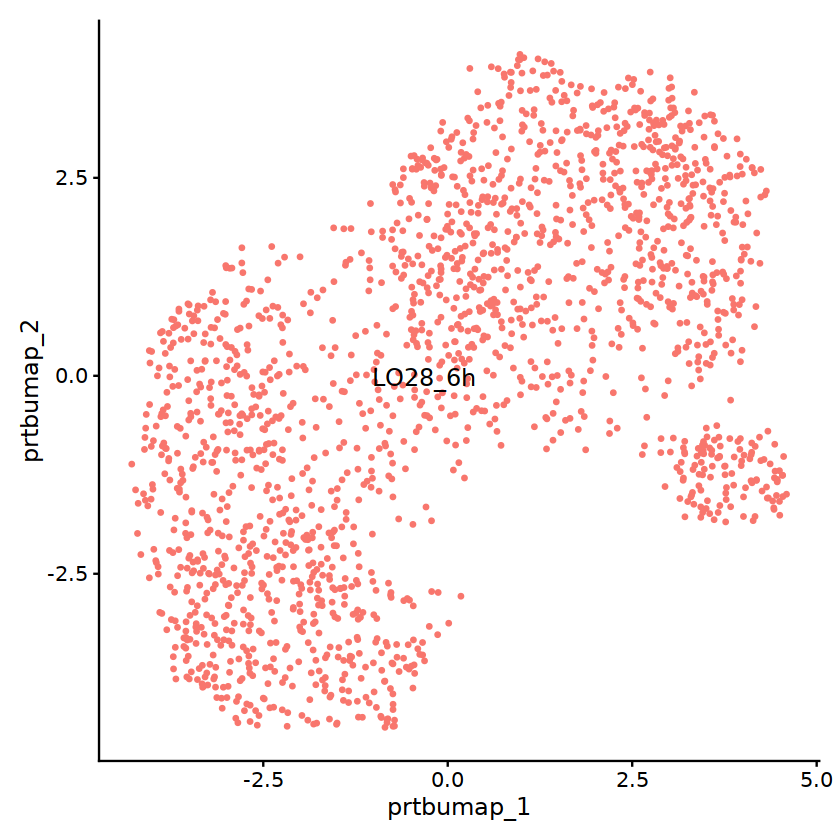

In [42]:
Idents(sub_test) <- "condition"

DimPlot(object = sub_test,
             reduction = "prtbumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO15_",'UMAP_PRTB_condition', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



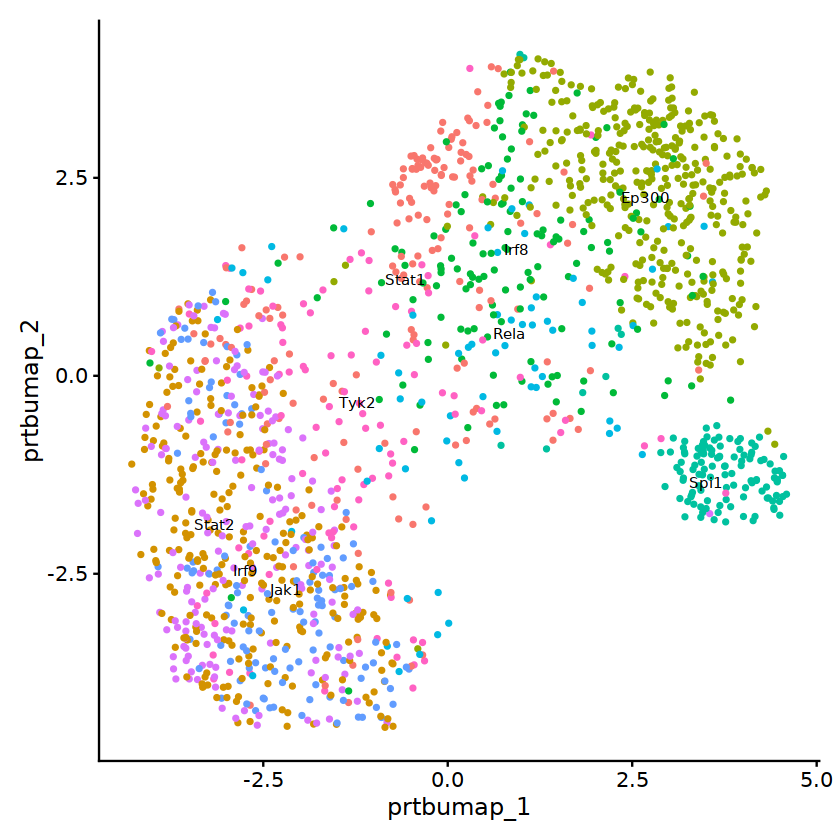

In [43]:
Idents(sub_test) <- "gene"

DimPlot(object = sub_test,
        cells=colnames(sub_test)[sub_test$mixscape_class!='NT'],
             reduction = "prtbumap", 
             repel = T, 
             label.size = 3, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO15_",'UMAP_PRTB_condition_KO', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

### LDA of PRTB perturbed & NT cells

In [44]:
# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(KO15) <- "mixscape_class.global"
sub <- subset(KO15, idents = c("KO", "NT"))

In [45]:
# Run LDA.
sub <- MixscapeLDA(
  object = sub, 
  assay = "RNA", 
  pc.assay = "PRTB", 
  labels = "gene", 
  nt.label = "NT", 
  npcs = 10, 
  logfc.threshold = 0.25, 
  verbose = F)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”


In [46]:
# Use LDA results to run UMAP and visualize cells on 2-D. 
# Here, we note that the number of the dimensions to be used is equal to the number of 
# labels minus one (to account for NT cells).
sub <- RunUMAP(
  object = sub,
  dims = 1:(length(unique(sub$mixscape_class))-1),
  reduction = 'lda',
  reduction.key = 'ldaumap',
  reduction.name = 'ldaumap')

16:57:35 UMAP embedding parameters a = 0.9922 b = 1.112

16:57:35 Read 1828 rows and found 9 numeric columns

16:57:35 Using Annoy for neighbor search, n_neighbors = 30

16:57:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:57:36 Writing NN index file to temp file /home/sreichl/tmp//RtmpOfqeWv/file6d01c31c723

16:57:36 Searching Annoy index using 1 thread, search_k = 3000

16:57:36 Annoy recall = 100%

16:57:37 Commencing smooth kNN distance calibration using 1 thread

16:57:37 Initializing from normalized Laplacian + noise

16:57:37 Commencing optimization for 500 epochs, with 73180 positive edges

16:57:43 Optimization finished

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ldaumap to ldaumap_”


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



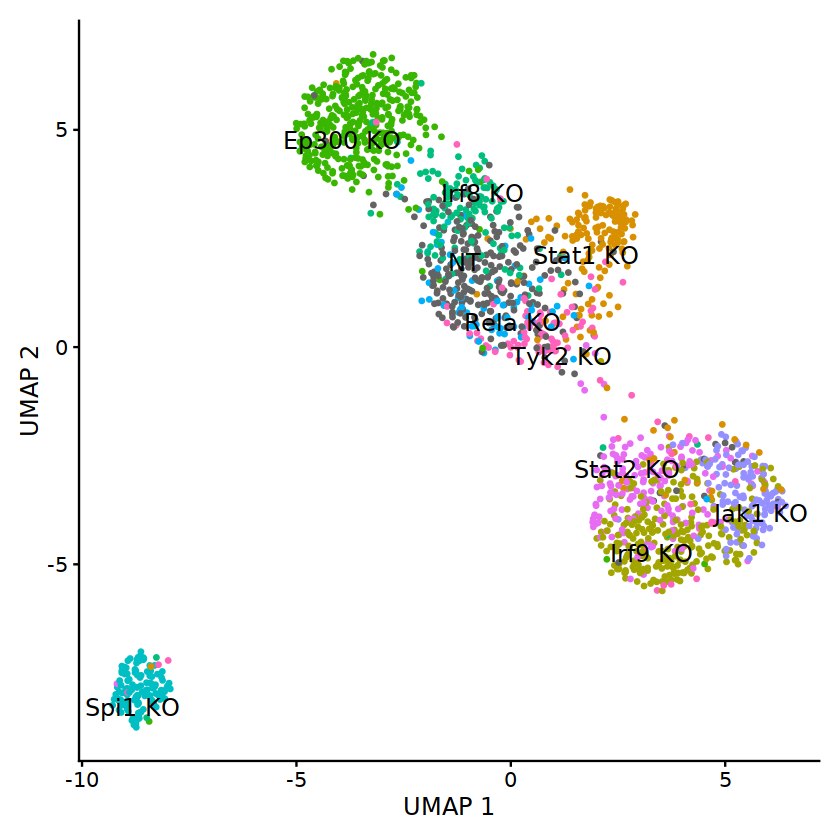

In [47]:
# Visualize UMAP clustering results.
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             reduction = "ldaumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO15_",'UMAP_LDA_KO_', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



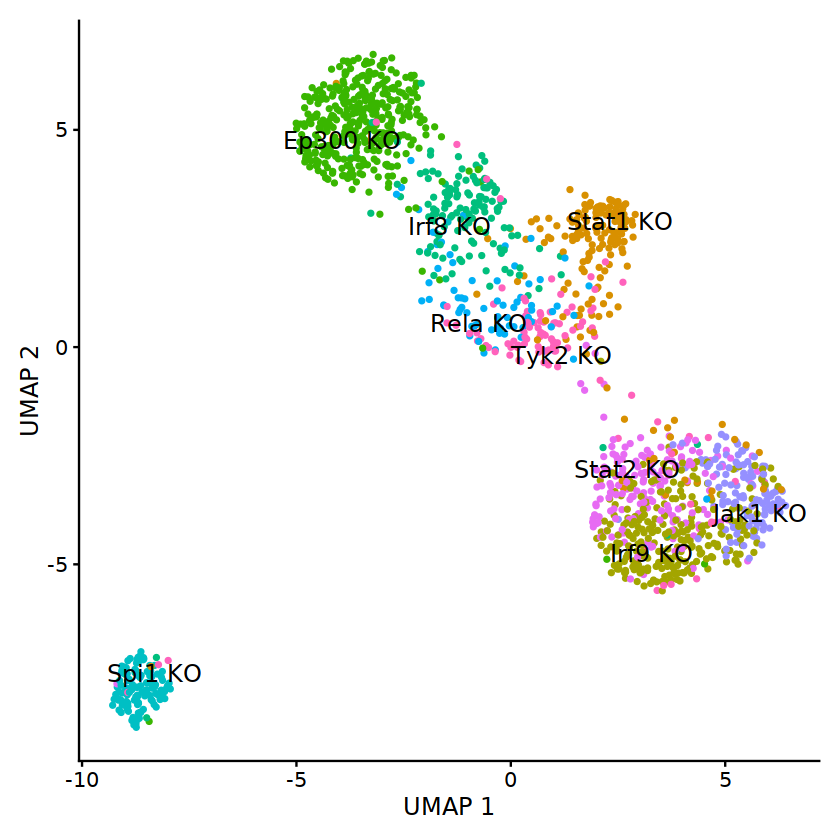

In [48]:
# Visualize UMAP clustering results without NT cells
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             cells=colnames(sub)[sub$mixscape_class!='NT'],
             reduction = "ldaumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO15_",'UMAP_LDA_KO_','pure', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



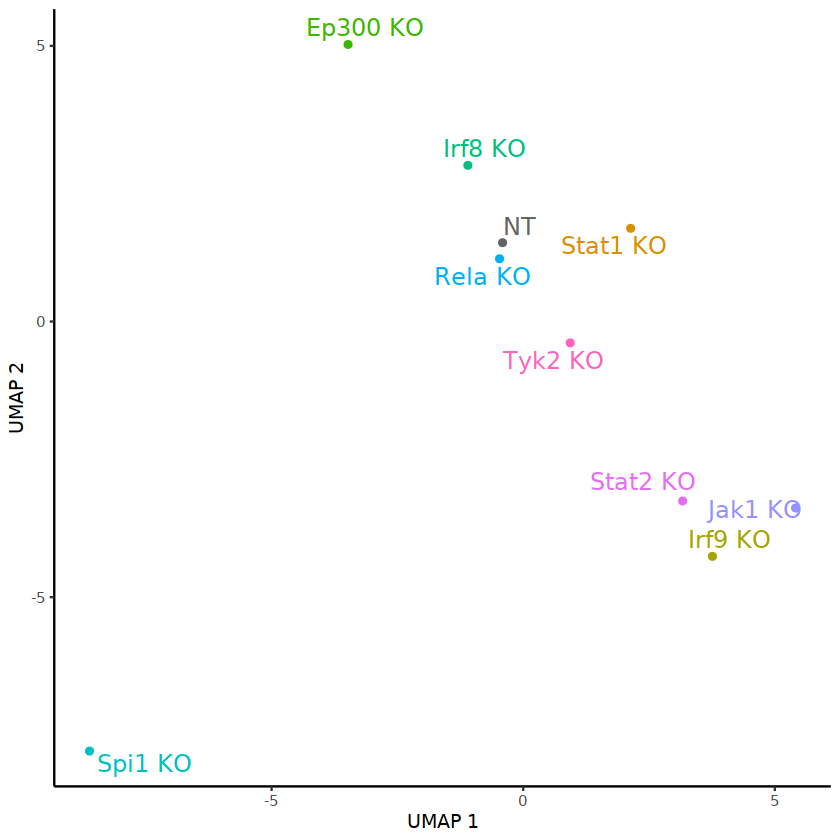

In [49]:
# plot only the centroids
ldaumap_data <- Embeddings(object = sub, reduction = "ldaumap")
ldaumap_data <- data.frame(ldaumap_data)
ldaumap_data$mixscape_class <- sub$mixscape_class[rownames(ldaumap_data)]

ldaumap_means <- aggregate(ldaumap_data[, c('ldaumap_1','ldaumap_2')], list(ldaumap_data$mixscape_class), mean)

p <- ggplot(ldaumap_means, aes(ldaumap_1, ldaumap_2, colour = Group.1)) + 
    geom_point()  + 
    geom_text_repel(aes(label=Group.1), size = 5)

p1 <-  p+ 
    scale_color_manual(values=col, drop=FALSE) +
    ylab("UMAP 2") +
    xlab("UMAP 1") +
    theme_classic()+ 
    NoLegend()

p1

ggsave(
  paste0("KO15_",'UMAP_LDA_KO_','centroids', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [50]:
# save Seurat object
saveRDS(sub, file = file.path(results_path,paste0("KO15_mixscape_subset_Seurat.rds")))

In [51]:
# loading Seurat object
sub <-readRDS(file = file.path(results_path,paste0("KO15_mixscape_subset_Seurat.rds")))
sub

An object of class Seurat 
33349 features across 1828 samples within 5 assays 
Active assay: PRTB (2214 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 6 dimensional reductions calculated: pca, umap, prtbpca, prtbumap, lda, ldaumap